# Import required packages

In [1]:
%matplotlib inline
import numpy as np
from collections import defaultdict
import sys
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import pickle
from nltk.tokenize import MWETokenizer
from scipy import stats
from collections import Counter
import json
import statsmodels.api as sm
import csv
import itertools 
from wordcloud import WordCloud, STOPWORDS
import mplcyberpunk
from matplotlib import font_manager
import re

# Preparing Disney font

Text(0.5, 0.5, 'Matplotlib for Storytellers')

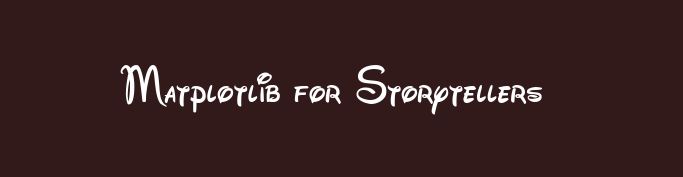

In [2]:
#https://colab.research.google.com/drive/1zb8_9OsKMX-Aav0QYIjRV3dDumRd56Wd?usp=sharing#scrollTo=6fb4d2db
locations = ["font"]
font_files = font_manager.findSystemFonts(fontpaths = locations)

for file in font_files:
    font_manager.fontManager.addfont(file)
    
fig, ax = plt.subplots(figsize = (12,3), facecolor = (.2, .1, .1))

ax.axis('off')
fig.text(0.5, 0.5, 'Matplotlib for Storytellers', ha = 'center', fontname = 'Disney Script', 
        size = 50, fontweight = 'extra bold', color = 'white', va = 'center')

In [3]:
#https://www.python-graph-gallery.com/custom-fonts-in-matplotlib
font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
font_manager.findfont("Disney Script") # Test with "Special Elite" too

'/Users/arenalyahya/Documents/GitHub/Disney-s-Director-and-Cast-Network/font/DisneyScript.ttf'

# Read from the file

In [4]:
def flushPrint(www):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % www)
    sys.stdout.flush()
    
#To manage the years in the dictionary (names2)
years_m = [1928,1941,1951,1961,1971,1981,1991,2001,2011, 2022]
years_p = ["1928-1940","1941-1950","1951-1960","1961-1970","1971-1980","1981-1990","1991-2000",
           "2001-2010","2011-2021"]

newYearCheck=[]#add any year that mentioned once

P={}
D={}
n=0
g = defaultdict(lambda:0)
gm = defaultdict(lambda:defaultdict(lambda:0))

#stoped here
names={}
names2 = defaultdict(lambda:defaultdict(lambda:0)) #names of people in each period 
count2 = defaultdict(lambda:defaultdict(lambda:0)) #period in a year for each actor

#names = defaultdict(lambda:defaultdict(lambda:0))
nameIndex =0

with open("disney_plus_titles.csv", 'r') as data:
    for line in csv.DictReader(data):
        # skip any movie or tv show that does not have cast or director.
        if not line['director'] or not line['cast']:
            continue  
        n += 1
        if n%10000 == 0:
            flushPrint(n/10000)
        
        # extract info
        s = line['show_id']
        m_type = line['rating'].replace('TV-', '')
        year =  int(line['release_year'])
        director = ['dr_' + i for i in line['director'].strip().replace('Dr. ', '').split(', ')]
        #'dr_' + line['director'].strip().split(',')
        cast = line['cast'].strip().replace('Dr. ', '').split(', ') 
        
        listt = director + cast
        
        period_out= "" 
        
        #choose the correct index in years_p
        for i,j in zip(range(0,len(years_m)-1), range(1,len(years_m))):
            if (years_m[i] <= year and year < years_m[j]):
                 period_out =  years_p[i]     
        
        
        # indexing all workers  
        for a in listt:
            if a not in names:
                #stoped here
                names[a]=nameIndex
                nameIndex+=1
            #indexing workers in each period 
            if a not in names2[period_out].values():
                names2[period_out][a]=names[a]
                #print(a)
                #count2 [period_out][a] = 0 #identfy with 0
        
        for a in listt:
            count2 [period_out][a] = count2[period_out][a] + 1
            #print(period_out + " " + a)
        
        # Indexed =[names[year][a] for a in listt] 
        indexed =[names[a] for a in listt] 

        # create relationship between the worker
        l = list((itertools.permutations(indexed , 2)))
        
        # Elimnate any redundancy in the list
        al = set([tuple(sorted(i)) for i in l]) 
        
        # Increment the weight
        for pair in al: 
            g[pair]+=1
            gm[period_out][pair]+=1
            
        
        
        #description or type
        if  year not in newYearCheck:
            newYearCheck.append(year)
            #D[year] =  line['description']
            D[year] =  line['listed_in']
            
        else:
            #D[year] =  D[year] + line['description']
            D[year] += ', ' + line['listed_in']
            
        #print (type(year))
        #zip som other values
        P[s]=[year,m_type,director,cast]

In [5]:
#extract the names for each period 
indexName2 = defaultdict(lambda:defaultdict(lambda:0))
for a in names2:
    indexName2[a]=dict([(v,k) for k,v in names2[a].items()]) 

#indexName2

In [7]:
indexName=dict([(v,k) for k,v in names.items()]) 
#indexName

# Create big network   

In [9]:
cololerlist={}         
for j in range(0,len(indexName)):
    i = " "
    if "dr_" in indexName[j]:
        i = "red" 
    else:
        i = "blue"    
    cololerlist[j] =  i;  

([], [])

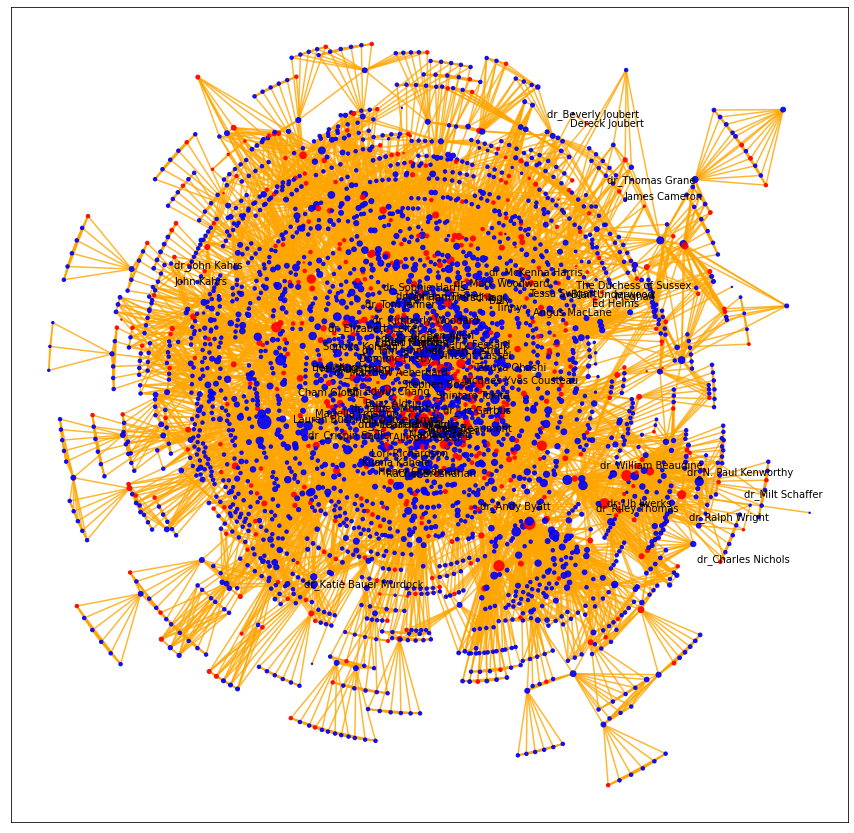

In [10]:
G=nx.Graph() 
for k in g: 
    v=g[k] 
    if v>=1: 
        i,j=k 
        G.add_edge(i, j, weight=v)
        
posG = nx.kamada_kawai_layout(G)
xG,yG = np.array(list(posG.values())).T 

degrees_ = [2*val for (node, val) in G.degree()]


plt.figure(figsize=(15, 15))
plt.scatter(xG,yG,s=degrees_,color=list(cololerlist.values()),zorder=2,alpha=0.9) 

for i,j in G.edges(): 
    xi,yi=posG[i] 
    xj,yj=posG[j] 
    plt.plot([xi,xj],[yi,yj],color='orange',zorder=1,alpha=0.8) 
    
delta=0.05 
for i in G: 
    if G.degree(i)==2: 
        xi,yi=posG[i] 
        plt.text(xi+delta,yi,indexName[i],ha='center',va='center') 
plt.xticks([])
plt.yticks([])

([], [])

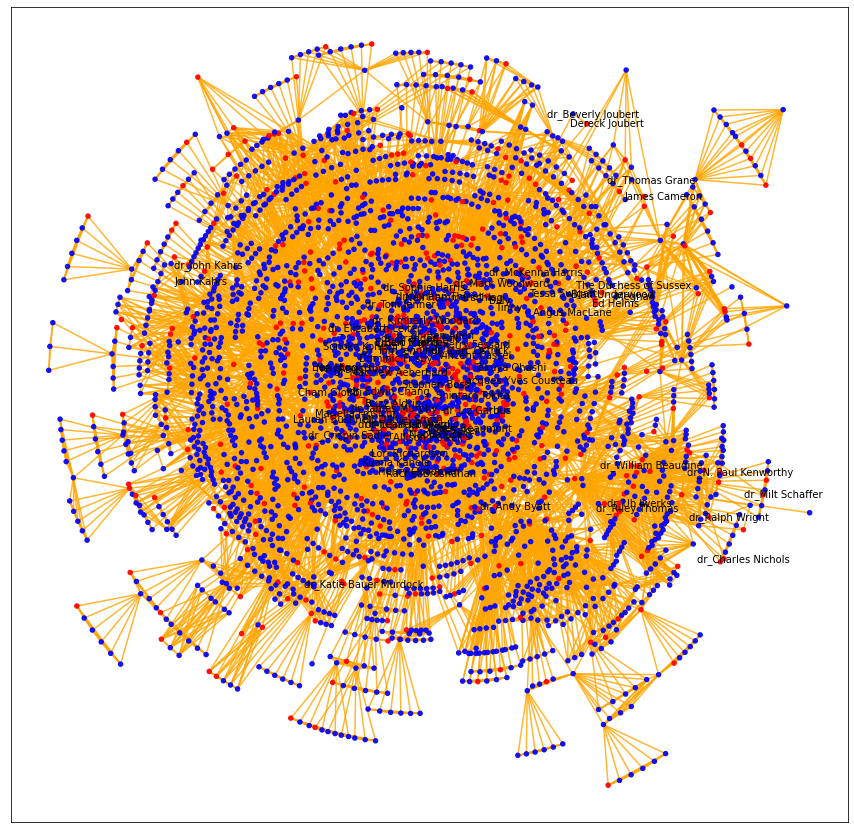

In [14]:
#no degree
plt.figure(figsize=(15, 15))
plt.scatter(xG,yG,s=20,color=list(cololerlist.values()),zorder=2,alpha=0.9) 

for i,j in G.edges(): 
    xi,yi=posG[i] 
    xj,yj=posG[j] 
    plt.plot([xi,xj],[yi,yj],color='orange',zorder=1,alpha=0.8) 
    
delta=0.05 
for i in G: 
    if G.degree(i)==2: 
        xi,yi=posG[i] 
        plt.text(xi+delta,yi,indexName[i],ha='center',va='center') 
plt.xticks([])
plt.yticks([])

# Create mutiple network  for each period

In [12]:
#Create the gragh in each period 
G2=defaultdict(lambda:nx.Graph())
for y in gm.keys():
    for k in gm[y]: 
        v=gm[y][k] 
        if v>=1: 
            i,j=k 
            G2[y].add_edge(i, j, weight=v)

In [13]:
#colloring the dots
cololerlist2=defaultdict(lambda:defaultdict(lambda:0))        
for a in indexName2:
    for j in indexName2[a].keys():
        i = ""
        if "dr_" in indexName2[a][j]:
            i = "red" 
        else:
            i = "purple"
        cololerlist2[a][j] =  i  

In [15]:
#sorting the periods
# sort the keys and store them in a new variable
sorted_value = sorted(G2.keys())
new_dict={}

# for all the values in sorted_value
for i in sorted_value:
   # match the key element with un-sorted dictionary
   for key, value in G2.items():
        if key == i:
            # when matched place the key and value in the new dict
            new_dict[key] = value

G2 = new_dict.copy()

In [16]:
#Create the postion option one
posG2 ={}
xG2 ={}
yG2={}
for y in G2.keys(): 
    posG2[y] = nx.spring_layout(G2[y], seed = 4)
    xG2[y],yG2[y] = np.array(list(posG2[y].values())).T 

In [17]:
#Create the postion option two
posG2 ={}
xG2 ={}
yG2={}
for y in G2.keys(): 
    posG2[y] = nx.kamada_kawai_layout(G2[y])
    xG2[y],yG2[y] = np.array(list(posG2[y].values())).T 

Text(0.5, 0.98, "Disney's Cast & Directors Relationship Over Periods of Years")

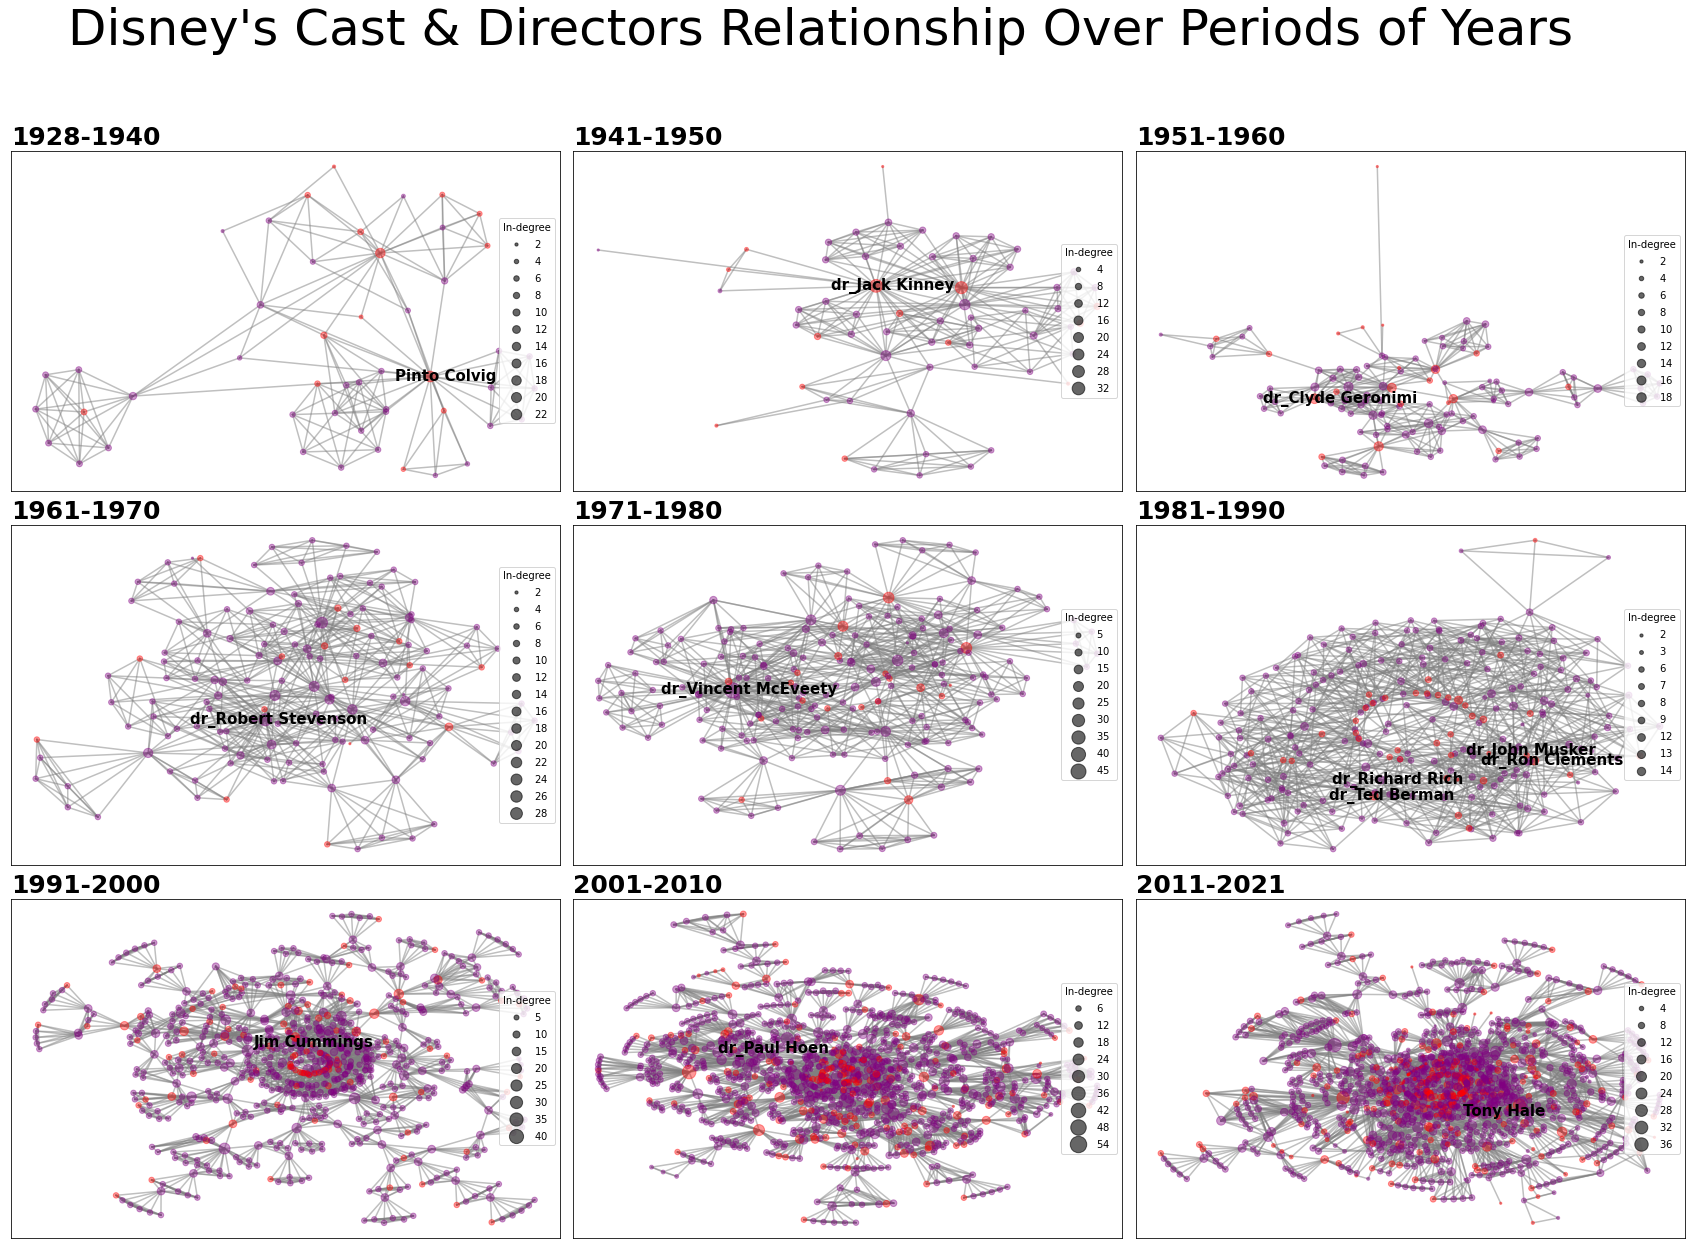

In [18]:
fig, ax = plt.subplots(figsize = (30, 20))
scatter =[]
handles=[] 
labels =[]

#for each period and indexes
for k,n in zip(G2.keys(),range(len(G2.keys()))):
    
    #extract the degree form the graph (multiply by two to increas the dot size)
    degrees = [5*val for (node, val) in G2[k].degree()]
    
    #ordering of each plot
    ax=plt.subplot(3,3,n+1)
    
    #scatter the cast member with the chosed coler
    scatter = plt.scatter(xG2[k],yG2[k],s=degrees,zorder=2,color=list(cololerlist2[k].values()),alpha=0.4)#, edgecolor="black") 

    #line the eges
    for i,j in G2[k].edges(): 
        xi,yi=posG2[k][i] 
        xj,yj=posG2[k][j] 
        plt.plot([xi,xj],[yi,yj],color='gray',zorder=1,alpha=0.5)
    
    #put the period on the left 
    plt.title(k,loc='left', fontsize=25,fontweight="bold")
    plt.xticks([])
    plt.yticks([])
    
    #extrat the handeler and the labels
    handles, labels= scatter.legend_elements(prop="sizes", alpha=0.6)
    
    labels_tmp=[]
    for i in labels:
        oldnum = re.findall(r'\d+', i)[0]
        newstr = str(int(int(oldnum)/5))
        labels_tmp.append(i.replace(oldnum, newstr))
    labels_tmp
    
    #put the sizes legend in the best place
    legend2 = ax.legend(handles, labels_tmp, loc='center right',  bbox_to_anchor=(1, 0.5), title="In-degree")
    
    delta=0.05 
    max1= 0
    for (node, val) in G2[k].degree():
        if max1 < val:
            max1 = val  
    
    for i in G2[k]:
        if G2[k].degree(i) == max1: 
            xi,yi=posG2[k][i] 
            plt.text(xi+delta,yi,indexName[i],ha='center',va='center',fontsize =15,fontweight="bold")

fig.subplots_adjust(wspace=0.025, hspace=0.10)

    

plt.suptitle( "Disney's Cast & Directors Relationship Over Periods of Years", size = 50)

#ax=plt.subplot(5,2,10)
#legend1 = ax.legend(scatter.legend_elements(),loc="lower left", title="Classes")
#ax.add_artist(legend1)

#plt.savefig('filename.png', dpi=300)

#ax.grid(True)
 
#plt.tight_layout()

# Pixidust insperation code

<ipython-input-19-3ad1f87221b8>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


([], [])

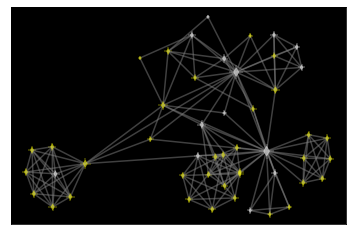

In [19]:
#testing on a small data
#working on small network
for j in indexName2["1928-1940"].keys():
    i = ""
    if "dr_" in indexName2["1928-1940"][j]:
        i = "white" 
    else:
        i = "yellow"
    cololerlist2["1928-1940"][j] =  i  
    

#extract the degree form the graph (multiply by two to increas the dot size)
degrees = [2*val for (node, val) in G2["1928-1940"].degree()]

degrees2 = [10*val for (node, val) in G2["1928-1940"].degree()]

plt.axes().set_facecolor("black")

ax = plt.axes()
ax.set_facecolor("black")

#scatter the cast member with the chosed coler
scatter = plt.scatter(xG2["1928-1940"],yG2["1928-1940"],s=degrees,zorder=2,
                      color=list(cololerlist2["1928-1940"].values()),alpha=0.4, marker = 'd')#, edgecolor="black") 

scatter = plt.scatter(xG2["1928-1940"],yG2["1928-1940"],s=degrees2,color=list(cololerlist2["1928-1940"].values()),zorder=1,alpha=0.3, marker = '+')

#line the eges
for i,j in G2["1928-1940"].edges(): 
    xi,yi=posG2["1928-1940"][i] 
    xj,yj=posG2["1928-1940"][j] 
    plt.plot([xi,xj],[yi,yj],color='gray',zorder=1,alpha=0.5)

    
plt.xticks([])
plt.yticks([])

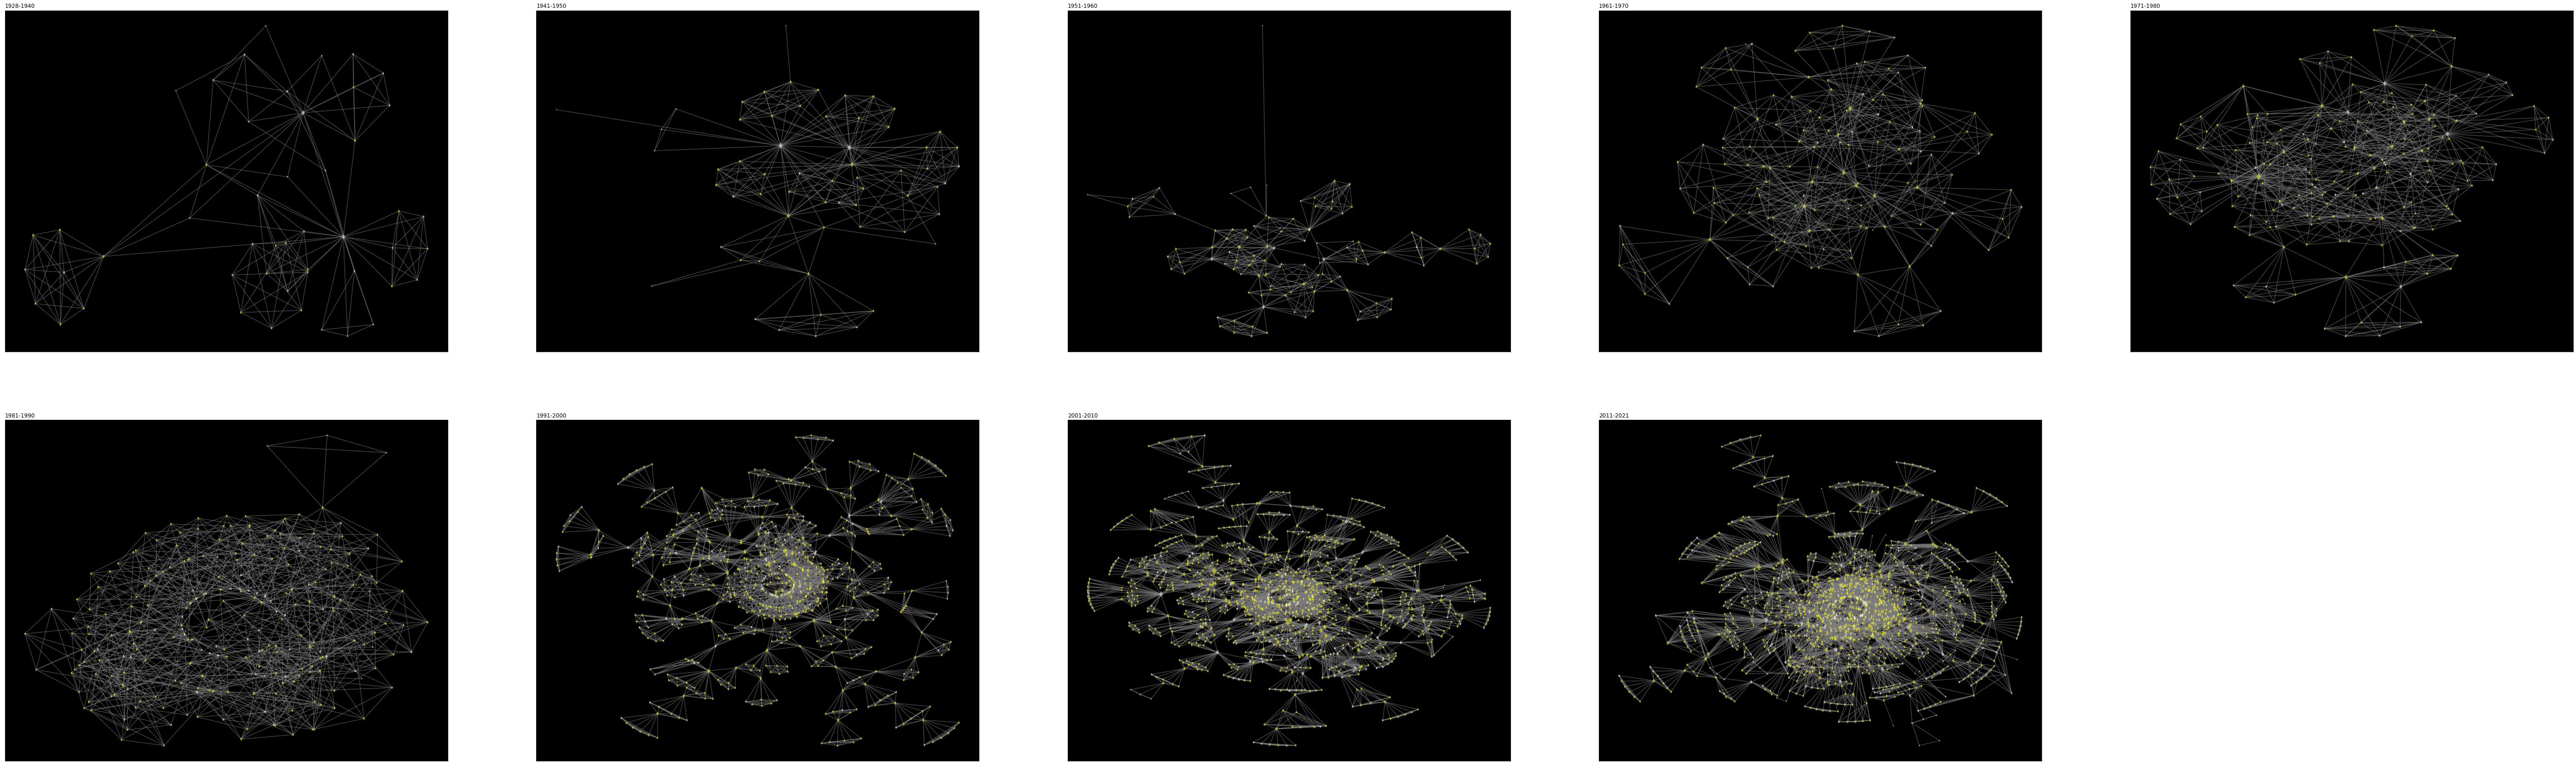

In [20]:
#colloring the dots
cololerlist2=defaultdict(lambda:defaultdict(lambda:0))        
for a in indexName2:
    for j in indexName2[a].keys():
        i = ""
        if "dr_" in indexName2[a][j]:
            i = "white" #directors
        else:
            i = "yellow"  #cast
        cololerlist2[a][j] =  i  
cololerlist2


fig, ax = plt.subplots(figsize = (100,30))
scatter =[]

#for each period and indexes
for k,n in zip(G2.keys(),range(len(G2.keys()))):
    
    #extract the degree form the graph (multiply by two to increas the dot size)
    degrees = [2*val for (node, val) in G2[k].degree()]
    degrees2 = [10*val for (node, val) in G2[k].degree()]
    
    #ordering of each plot
    ax=plt.subplot(2,5,n+1)
    ax.set_facecolor("black")

    
    #scatter the cast member with the chosed coler
    scatter = plt.scatter(xG2[k],yG2[k],s=degrees,zorder=2,color=list(cololerlist2[k].values()),alpha=0.4, marker = 'd') 
    scatter = plt.scatter(xG2[k],yG2[k],s=degrees,zorder=1,color=list(cololerlist2[k].values()),alpha=0.3, marker = '+')

    #line the eges
    for i,j in G2[k].edges(): 
        xi,yi=posG2[k][i] 
        xj,yj=posG2[k][j] 
        plt.plot([xi,xj],[yi,yj],color='gray',zorder=1,alpha=0.5)
    
    #put the period on the left 
    plt.title(k,loc='left')
    plt.xticks([])
    plt.yticks([])
    

(-0.9704805195331574,
 1.0634334862232209,
 -0.9563529372215271,
 1.0931596636772156)

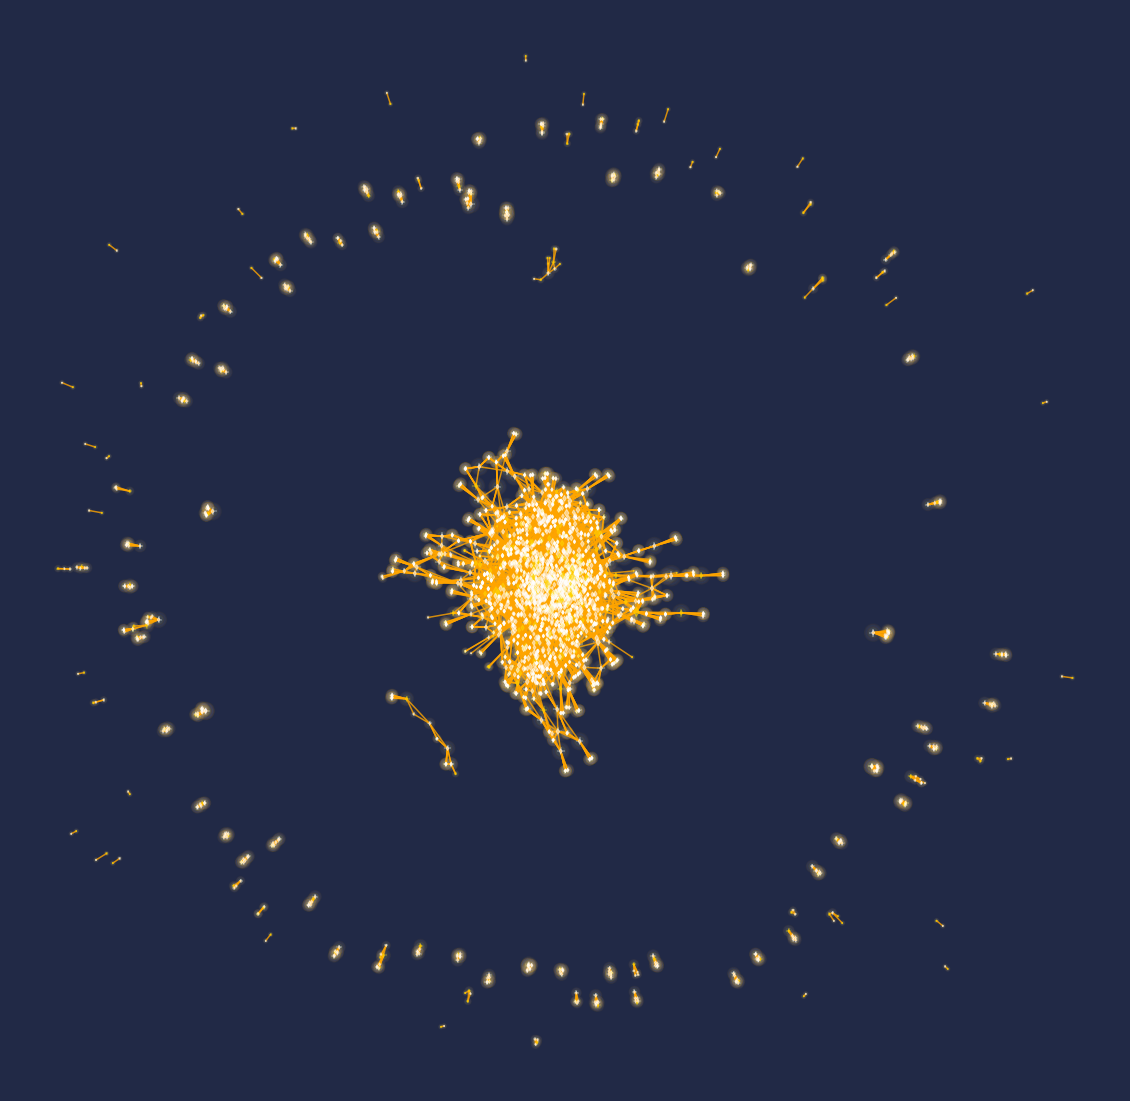

In [23]:
#working on big network (spark)
#problems: I wnated to be like tinker bell
indexName=dict([(v,k) for k,v in names.items()]) 
indexName

cololerlist={}         
for j in range(0,len(indexName)):
    i = " "
    if "dr_" in indexName[j]:
        i = "gold" 
    else:
        i = "white"    
    cololerlist[j] =  i;    


G=nx.Graph() 
for k in g: 
    v=g[k] 
    if v>=1: 
        i,j=k 
        G.add_edge(i, j, weight=v)
        
posG = nx.spring_layout(G)

xG,yG = np.array(list(posG.values())).T 

degrees_ = [val for (node, val) in G.degree()]
degrees_2 = [5*val for (node, val) in G.degree()]


plt.figure(figsize=(20, 20))


plt.style.use('cyberpunk')

ax = plt.axes()
#ax.set_facecolor("black")

plt.scatter(xG,yG,s=degrees_,color=list(cololerlist.values()),zorder=2,alpha=0.5, marker = 'd')
plt.scatter(xG,yG,s=degrees_2,color=list(cololerlist.values()),zorder=1,alpha=0.4, marker = '+')

mplcyberpunk.make_scatter_glow()

for i,j in G.edges(): 
    xi,yi=posG[i] 
    xj,yj=posG[j] 
    plt.plot([xi,xj],[yi,yj],color='orange',zorder=1,alpha=0.8) 

plt.xticks([])
plt.yticks([])
plt.axis("off")
#delta=0.05 
#for i in G: 
#    if G.degree(i)==1: 
#        xi,yi=posG[i] 
#        plt.text(xi+delta,yi,indexName[i],ha='center',va='center') 


(0.07646837544307217,
 9.938045341085436,
 -0.13063612174956762,
 13.858792661486007)

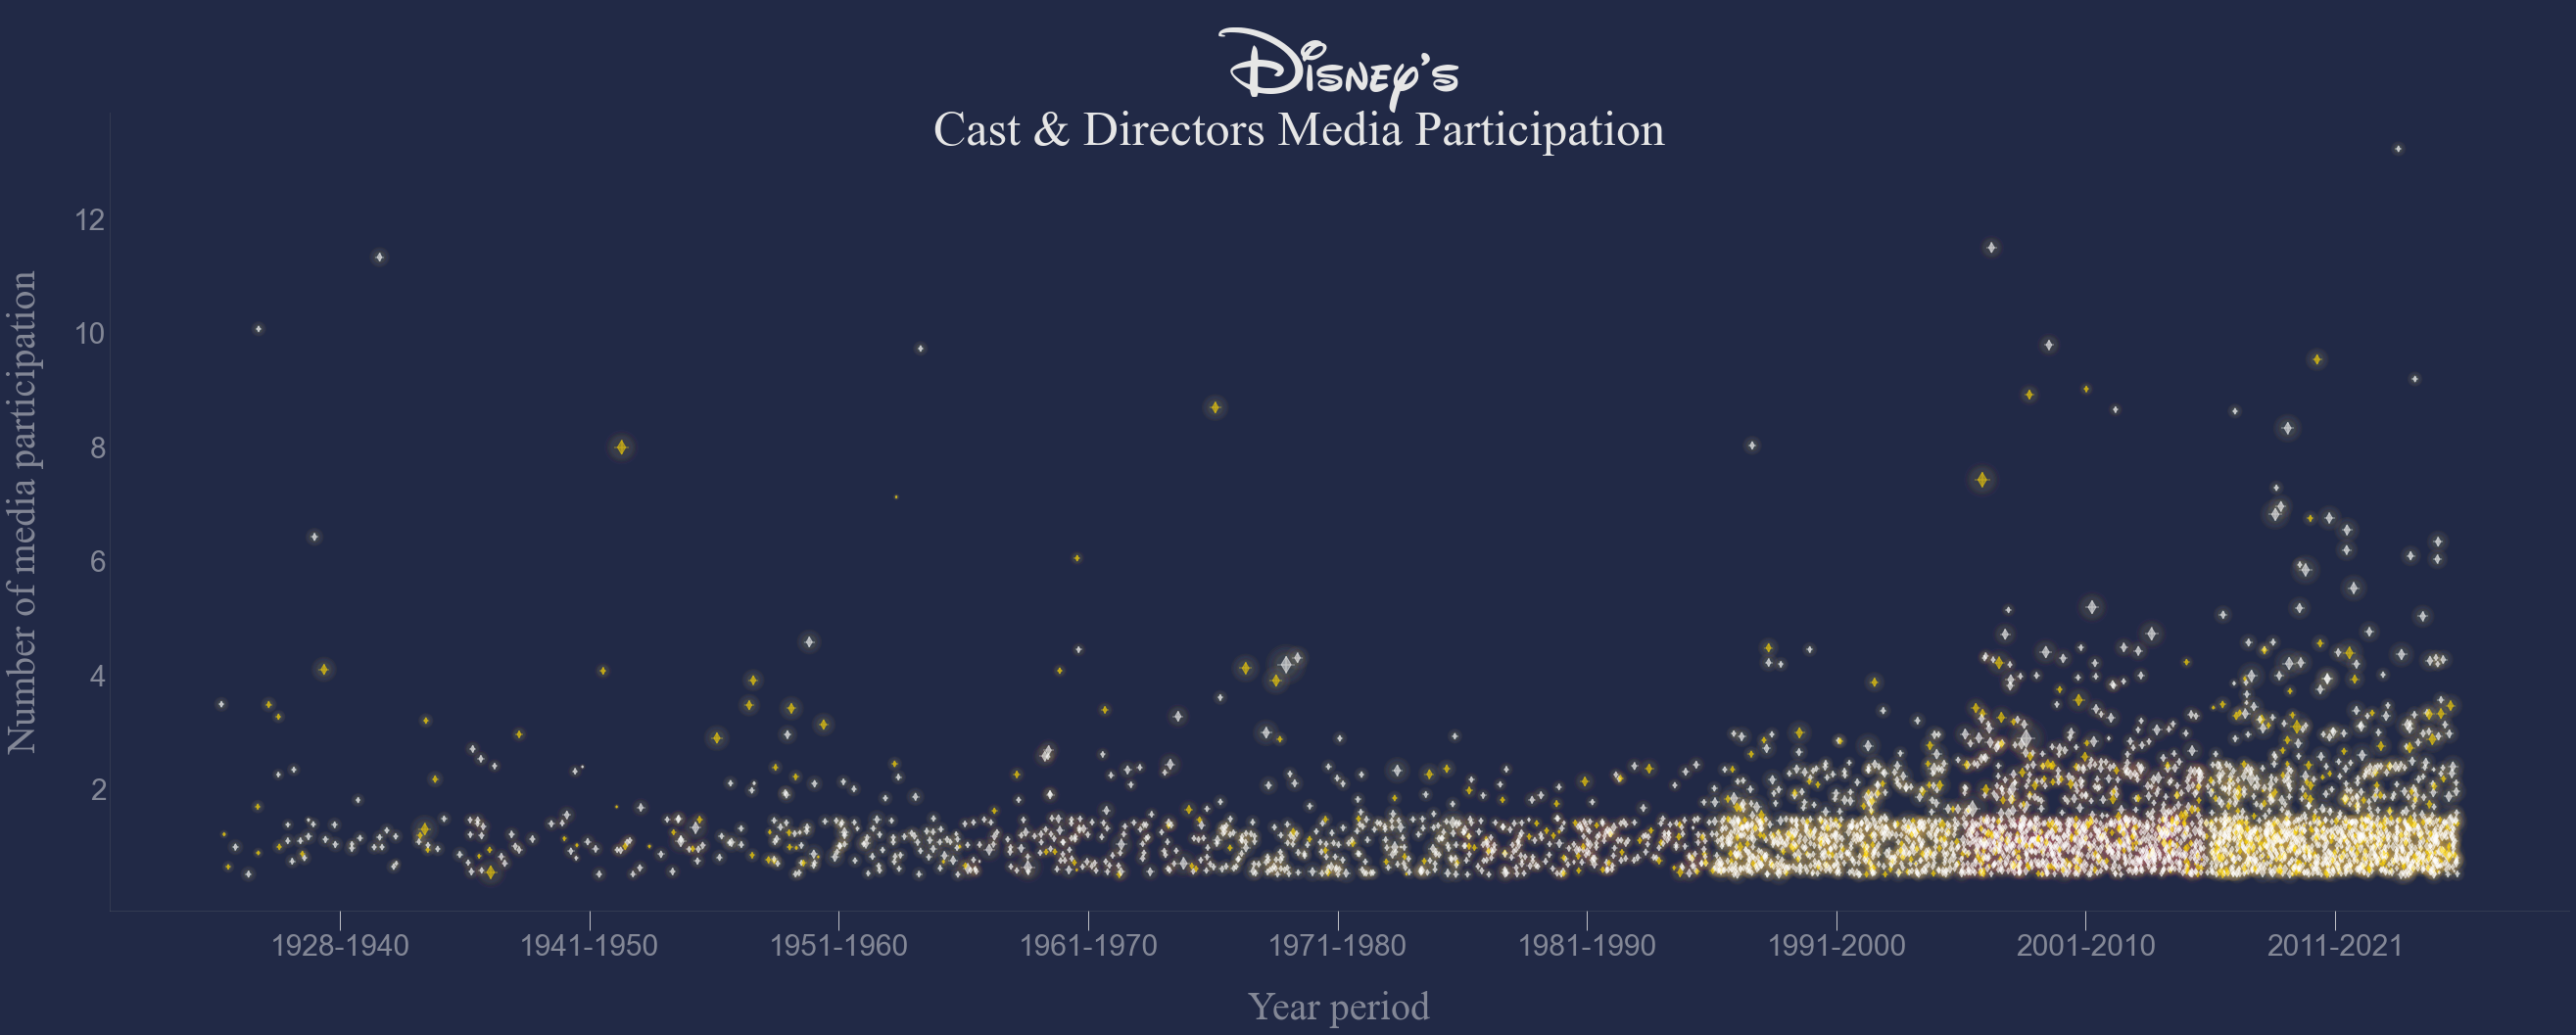

In [22]:
scatter =[]
period = 1;

m = list(np.arange(1,len(years_p)+1))
m

#plt.figure()
fig, ax = plt.subplots(figsize=(45, 15))


ax.set_xticks(m)

plt.style.use('cyberpunk')

#https://matplotlib.org/3.1.0/gallery/style_sheets/dark_background.html
#plt.style.use('dark_background')



#colloring the dots
cololerlist2=defaultdict(lambda:defaultdict(lambda:0))        
for a in indexName2:
    for j in indexName2[a].keys():
        i = ""
        if "dr_" in indexName2[a][j]:
            i = "gold" #director
        else:
            i = "white" #cast
        cololerlist2[a][j] =  i  
#cololerlist2



#for each period and indexes
for k,n in zip(G2.keys(),range(len(G2.keys()))):
    
    
    #extract the degree form the graph (multiply by two to increas the dot size)
    degrees = [3*val for (node, val) in G2[k].degree()]
    degrees2 = [7*val for (node, val) in G2[k].degree()]
    
    lst = [period] * len(degrees)
    
    random_y  = np.random.rand(len(count2[k].values())) - 0.5
    
    #https://stackoverflow.com/questions/53093560/python-scatter-plot-overlapping-data
    jittered_y = np.array(list(count2[k].values())) + .99 * random_y
    jittered_x = lst + .99 * np.random.rand(len(lst)) - 0.5
    
    #scatter the cast member with the chosed coler
    scatter = plt.scatter(jittered_x,jittered_y,s=degrees,zorder=2,color=list(cololerlist2[k].values()),alpha=0.5, marker = 'd') 
    scatter = plt.scatter(jittered_x,jittered_y,s=degrees2,zorder=1,color=list(cololerlist2[k].values()),alpha=0.4, marker = '+')


    mplcyberpunk.make_scatter_glow()
    
    #line the eges
    #for i,j in G2[k].edges(): 
        #xi,yi=posG2[k][i] 
        #xj,yj=posG2[k][j] 
        #plt.plot([xi,xj],[yi,yj],color='gray',zorder=1,alpha=0.5)
    #max1= 0
    #for (node, val) in G2[k].degree():
    #    if max1 < val:
    #        max1 = val        
    
    #count = 0
    #delta = .1
    #for i in G2[k]: 
    #    if G2[k].degree(i) == max1: 
    #        yi = jittered_y[count]
    #        xi = jittered_x[count]
    #        #plt.text(xi+delta,yi,indexName2[k][i],ha='center',va='center', fontsize=25,fontname="Disney Script", color ="g" ) 
    #        plt.text(xi+delta,yi,max1,ha='center',va='center', fontsize=25,fontname="Disney Script", color ="g" ) 

    #    count = count + 1
      

        
    
    period = period+ 1
    

    
#put the period on the left 

plt.title("Disney's", size = 89 , fontname="Disney Script")
plt.suptitle( "\n\nCast & Directors Media Participation", size = 50, fontname="Times New Roman",)

#plt.xticks([])
#plt.yticks([])
#ax.set_facecolor("black")

labels = years_p
ax.set_xticklabels(labels, alpha = .5)


labels = [item.get_text() for item in ax.get_yticklabels()]
#labels[1] = 'Testing'
#ax.set_yticklabels(labels)

ax.yaxis.get_major_ticks()[1].label1.set_visible(False)

#https://stackoverflow.com/questions/49110282/changing-alpha-value-of-ticklabels-without-specifying-text
plt.setp(ax.get_yticklabels(), alpha=0.5)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#https://towardsdatascience.com/handling-plot-axis-spines-in-python-f143b8554da2
ax.grid(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines['bottom'].set_linestyle("solid")

ax.spines['left'].set_linewidth(1)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color('gray')

ax.spines['bottom'].set_alpha(0.2)
ax.spines['left'].set_alpha(0.2)



ax.tick_params(axis='x', size=20)#, rotation=20)
ax.tick_params(axis='both', which='major', labelsize=30)

#https://stackoverflow.com/questions/67253174/how-to-set-space-between-the-axis-and-the-label/67253601
plt.xlabel('Year period', fontsize=40,  fontname = "Times New Roman", alpha =.5,  labelpad=30)
plt.ylabel('Number of media participation', fontsize=40, fontname = "Times New Roman", alpha =.5, labelpad=30)
plt.axis('on')

